In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Sun Jan 14 01:50:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    17W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.resblock_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.resblock_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.n_blocks = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 59.36157989501953
encoder.downs 5.989013671875
encoder.blocks 53.35693359375
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 19.359989166259766
decoder.linear 0.0234375
decoder.ups 5.9820556640625
decoder.blocks 13.31787109375
decoder.out_conv 0.036624908447265625
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.13-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 696092
-rw-rw-r-- 1 scpark scpark   1232900  1월 14 01:50 events.out.tfevents.1705163089.GPUSVR01
-rw-rw-r-- 1 scpark scpark 353231169  1월 14 01:44 save_10000
-rw-rw-r-- 1 scpark scpark 353218101  1월 14 01:24 save_0
-rw-rw-r-- 1 scpark scpark   1005668  1월 14 01:24 events.out.tfevents.1705162071.GPUSVR01
-rw-rw-r-- 1 scpark scpark   1880266  1월 14 01:07 events.out.tfevents.1705160155.GPUSVR01
-rw-rw-r-- 1 scpark scpark    589796  1월 14 00:35 events.out.tfevents.1705159621.GPUSVR01
-rw-rw-r-- 1 scpark scpark    328196  1월 14 00:26 events.out.tfevents.1705159065.GPUSVR01
-rw-rw-r-- 1 scpark scpark   1288868  1월 14 00:17 events.out.tfevents.1705157484.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


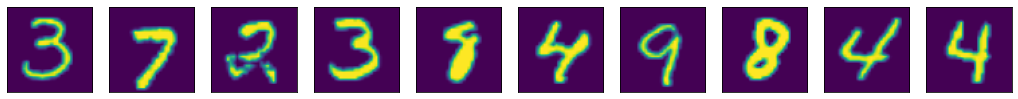

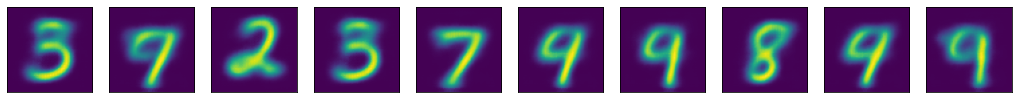

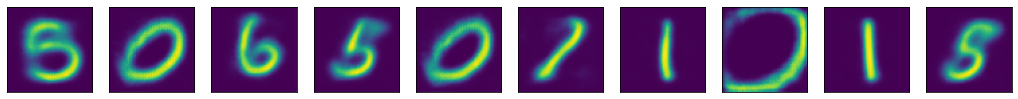

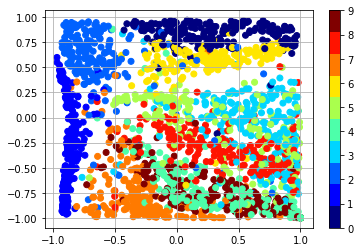

1001
lse_loss 0.011443834751844406
recon_loss 0.13243094086647034
1002
lse_loss 0.009183751419186592
recon_loss 0.13430693745613098
1003
lse_loss 0.012347488664090633
recon_loss 0.1310848891735077
1004
lse_loss 0.012658434920012951
recon_loss 0.14102111756801605
1005
lse_loss 0.01187799870967865
recon_loss 0.14248204231262207
1006
lse_loss 0.011567852459847927
recon_loss 0.1322076916694641
1007
lse_loss 0.010646166279911995
recon_loss 0.13996794819831848
1008
lse_loss 0.012877995148301125
recon_loss 0.1342117339372635
1009
lse_loss 0.0127267399802804
recon_loss 0.1413966715335846
1010
lse_loss 0.012149229645729065
recon_loss 0.1381455510854721
1011
lse_loss 0.012375080026686192
recon_loss 0.12976384162902832
1012
lse_loss 0.01237647794187069
recon_loss 0.142245814204216
1013
lse_loss 0.011040907353162766
recon_loss 0.13257157802581787
1014
lse_loss 0.010616886429488659
recon_loss 0.13249599933624268
1015
lse_loss 0.012561577372252941
recon_loss 0.1398552656173706
1016
lse_loss 0.012813

lse_loss 0.014242752455174923
recon_loss 0.13668391108512878
1129
lse_loss 0.014378995634615421
recon_loss 0.14004597067832947
1130
lse_loss 0.011835400015115738
recon_loss 0.13636469841003418
1131
lse_loss 0.011119543574750423
recon_loss 0.134609192609787
1132
lse_loss 0.012875568121671677
recon_loss 0.14501163363456726
1133
lse_loss 0.011517363600432873
recon_loss 0.12976662814617157
1134
lse_loss 0.01084208581596613
recon_loss 0.13371151685714722
1135
lse_loss 0.011503377929329872
recon_loss 0.13754892349243164
1136
lse_loss 0.01253779511898756
recon_loss 0.13474658131599426
1137
lse_loss 0.011453366838395596
recon_loss 0.13548040390014648
1138
lse_loss 0.011602730490267277
recon_loss 0.14562787115573883
1139
lse_loss 0.01490862388163805
recon_loss 0.1253328025341034
1140
lse_loss 0.011706932447850704
recon_loss 0.1368991583585739
1141
lse_loss 0.011885660700500011
recon_loss 0.13378772139549255
1142
lse_loss 0.011690876446664333
recon_loss 0.12480771541595459
1143
lse_loss 0.012691

lse_loss 0.011531527154147625
recon_loss 0.13428787887096405
1254
lse_loss 0.010802341625094414
recon_loss 0.1324746310710907
1255
lse_loss 0.012410440482199192
recon_loss 0.1414535790681839
1256
lse_loss 0.010385654866695404
recon_loss 0.12884898483753204
1257
lse_loss 0.010298742912709713
recon_loss 0.12831203639507294
1258
lse_loss 0.010136893019080162
recon_loss 0.12743522226810455
1259
lse_loss 0.01384827308356762
recon_loss 0.1342514008283615
1260
lse_loss 0.012597238644957542
recon_loss 0.1290019303560257
1261
lse_loss 0.010899863205850124
recon_loss 0.14087864756584167
1262
lse_loss 0.01160425040870905
recon_loss 0.12811192870140076
1263
lse_loss 0.012498278170824051
recon_loss 0.1312549114227295
1264
lse_loss 0.015243016183376312
recon_loss 0.1291516274213791
1265
lse_loss 0.011168000288307667
recon_loss 0.13192448019981384
1266
lse_loss 0.015271139331161976
recon_loss 0.13209891319274902
1267
lse_loss 0.010921075940132141
recon_loss 0.13474488258361816
1268
lse_loss 0.0121422

1380
lse_loss 0.012366018258035183
recon_loss 0.13025280833244324
1381
lse_loss 0.010401707142591476
recon_loss 0.13622479140758514
1382
lse_loss 0.010958642698824406
recon_loss 0.12757417559623718
1383
lse_loss 0.01367165893316269
recon_loss 0.13866069912910461
1384
lse_loss 0.010919931344687939
recon_loss 0.14094826579093933
1385
lse_loss 0.012174264527857304
recon_loss 0.12722432613372803
1386
lse_loss 0.009813528507947922
recon_loss 0.13331569731235504
1387
lse_loss 0.011073214001953602
recon_loss 0.1340240240097046
1388
lse_loss 0.011850337497889996
recon_loss 0.1287229061126709
1389
lse_loss 0.011188368313014507
recon_loss 0.12810063362121582
1390
lse_loss 0.011564335785806179
recon_loss 0.12680873274803162
1391
lse_loss 0.011237295344471931
recon_loss 0.1332819163799286
1392
lse_loss 0.012456299737095833
recon_loss 0.134941965341568
1393
lse_loss 0.011183048598468304
recon_loss 0.1368112564086914
1394
lse_loss 0.012563513591885567
recon_loss 0.1378556340932846
1395
lse_loss 0.01

lse_loss 0.013004731386899948
recon_loss 0.13924574851989746
1506
lse_loss 0.011221184395253658
recon_loss 0.13993340730667114
1507
lse_loss 0.011886443011462688
recon_loss 0.12202345579862595
1508
lse_loss 0.010958824306726456
recon_loss 0.1320725977420807
1509
lse_loss 0.014320709742605686
recon_loss 0.13521291315555573
1510
lse_loss 0.011399020440876484
recon_loss 0.12361743301153183
1511
lse_loss 0.010569404810667038
recon_loss 0.1214524358510971
1512
lse_loss 0.012623939663171768
recon_loss 0.1410941779613495
1513
lse_loss 0.011253731325268745
recon_loss 0.12623637914657593
1514
lse_loss 0.011488362215459347
recon_loss 0.1415586918592453
1515
lse_loss 0.011383065022528172
recon_loss 0.1257718950510025
1516
lse_loss 0.011233881115913391
recon_loss 0.13107459247112274
1517
lse_loss 0.013189761899411678
recon_loss 0.122184157371521
1518
lse_loss 0.012065773829817772
recon_loss 0.13322222232818604
1519
lse_loss 0.010702423751354218
recon_loss 0.13813498616218567
1520
lse_loss 0.013074

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        